# **American Sign Language Recognition**

American Sign Language, typically referred to as ASL, is a visual language characterized by the formation of manual signs. ASL utilizes a unique form of syntax to communicate thoughts, feelings, and ideas. Due to discrepancies in census data, the number of American citizens living within Deaf culture and communicating with ASL is widely disputed. However, many sources claim that ASL is the third most widely used language in the United States, following English and Spanish.

The question is, How to reduce the communication gap between the normal people who aren't familiar with ASL and the large community of people having hearing or speech impairments. So, here comes the role of people like us having superpower of technology. Here's a small attempt of me using that superpower to create an AI based system which can recognize as well as translate few static signs in ASL using computer vision.

# **Dependencies**

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD, Adam
import pickle

# **Overview of Data**

In [ ]:
training_dir="data/asl51-classes"
content=sorted(os.listdir(training_dir))
print(content)
len(content)

# **Image Data Augmentation**

In [ ]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.2
)

train_generator = data_generator.flow_from_directory(training_dir, target_size=(200,200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=200, subset="training")

validation_generator = data_generator.flow_from_directory(training_dir, target_size=(200, 200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=50, subset="validation")

# **Transfer Learning based Model Training**

In [35]:
WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = keras.applications.inception_v3.InceptionV3(
    input_shape = (200, 200, 3), 
    include_top = False, 
    weights = 'imagenet'
)

inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 99, 99, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 99, 99, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 99, 99, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

# **Workflow of InceptionV3 Model**

In [36]:
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [37]:
from tensorflow.keras import layers
x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(76, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    #optimizer=SGD(lr=0.0001, momentum=0.9),
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [38]:
LOSS_THRESHOLD = 0.02
ACCURACY_THRESHOLD = 0.99

class ModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
            print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
            self.model.stop_training = True

callback = ModelCallback()

In [39]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 4,
    restore_best_weights =True,
)

In [41]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=200,
    validation_steps=200,
    epochs=500,
    #callbacks=[callback]
    callbacks=[early_stopping]
)

Epoch 1/500
200/200 [==============================] - 754s 4s/step - loss: 0.1630 - acc: 0.9571 - val_loss: 2.6908 - val_acc: 0.7959
Epoch 2/500
200/200 [==============================] - 791s 4s/step - loss: 0.1208 - acc: 0.9708 - val_loss: 0.3324 - val_acc: 0.9143
Epoch 3/500
200/200 [==============================] - 749s 4s/step - loss: 0.0599 - acc: 0.9848 - val_loss: 0.9792 - val_acc: 0.8347
Epoch 4/500
200/200 [==============================] - 751s 4s/step - loss: 0.0497 - acc: 0.9874 - val_loss: 0.3610 - val_acc: 0.9112
Epoch 5/500
200/200 [==============================] - 733s 4s/step - loss: 0.0913 - acc: 0.9805 - val_loss: 1.1308 - val_acc: 0.8196
Epoch 6/500
200/200 [==============================] - 756s 4s/step - loss: 0.0535 - acc: 0.9876 - val_loss: 0.1879 - val_acc: 0.9545
Epoch 7/500
200/200 [==============================] - 727s 4s/step - loss: 0.0271 - acc: 0.9926 - val_loss: 0.2290 - val_acc: 0.9492
Epoch 8/500
200/200 [==============================] - 797s 4s

In [42]:
model.save('transferlearning.h5')

In [46]:
loss, acc = model.evaluate(validation_generator)

1216/1216 [==============================] - 763s 628ms/step - loss: 0.1822 - acc: 0.9518


# **Evaluation Metrics**

<Figure size 432x288 with 0 Axes>

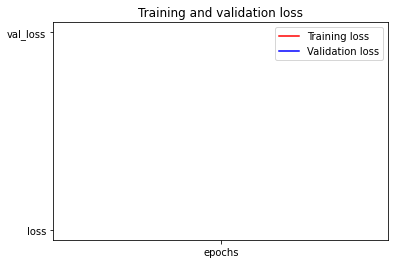

<Figure size 432x288 with 0 Axes>

In [43]:
plt.plot('epochs', 'loss', 'r', label='Training loss')
plt.plot('epochs', 'val_loss', 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

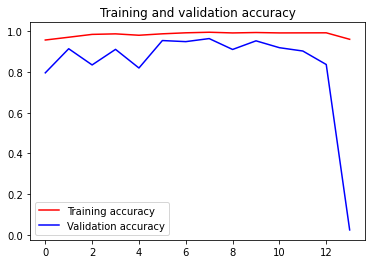

<Figure size 432x288 with 0 Axes>

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()

KeyError: 'accuracy'

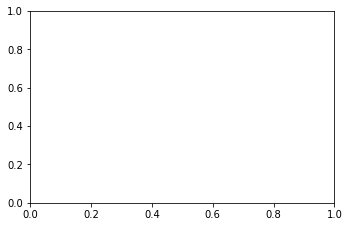

In [45]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()